In [1]:
import wandb
import random
import numpy as np
import pandas as pd

from svm_proxy import *
from attackers import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
class test_proxy:

    def __init__(self, proxy, attacker, X_val, y_val, log):
        """
        inputs   : proxy = incremental model object
                   attacker = attacker object
                   X_valid, y_valid = dataset for accuracy metric
                   log = whether to log in wandb
        """
        self.log = log
        self.run = None
        self.proxy = proxy
        self.attacker = attacker
        self.proxy_acc = None
        self.attacker_acc = None

        # stored dataset
        self.X_val, self.y_val = X_val, y_val

        if self.log:
            self.run = wandb.init('model_security')
        
        else:
            self.proxy_acc_plot = []
            self.attacker_acc_plot = []
            self.acc_diff_plot = []


    def steal(self, max_queries): 

        for query in range(max_queries):

            x, y = self.attacker.query_fit() # query and improve fit; return the query point
            self.attacker_acc = accuracy_score(self.attacker.predict(self.X_val), self.y_val)

            proxy.update(x, y)
            if query == 0:
                self.proxy_acc = accuracy_score(self.proxy.predict(self.X_val), self.y_val)
            else:
                self.proxy_acc = max(self.proxy_acc, accuracy_score(self.proxy.predict(self.X_val), self.y_val))

            if self.log:
                wandb.log({
                    "proxy_acc" : self.proxy_acc,
                    "attacker_acc" : self.attacker_acc,
                    'acc_diff' : self.proxy_acc - self.attacker_acc,
                })
            
            else:
                self.proxy_acc_plot.append(self.proxy_acc)
                self.attacker_acc_plot.append(self.attacker_acc)
                self.acc_diff_plot.append(self.proxy_acc - self.attacker_acc)


        if self.log:
            self.run.finish()
        
        else:
            plt.figure(figsize = (15, 8))
            plt.plot(range(len(self.proxy_acc_plot)), self.proxy_acc_plot, label = 'proxy_acc')
            plt.plot(range(len(self.attacker_acc_plot)), self.attacker_acc_plot, label = 'attacker_acc')
            plt.plot(range(len(self.acc_diff_plot)), self.acc_diff_plot, label = 'acc_diff')
            plt.yticks([0.1 * i for i in range(10)])
            plt.legend()
                

## Naive testing

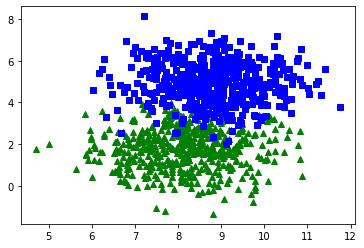

SVC(kernel='poly')

In [220]:
from sklearn import datasets
from sklearn.svm import SVC

X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 61)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

true_clf = SVC(kernel = 'poly')
# clf = SGDClassifier()
# clf = LogisticRegression()
true_clf.fit(X, y)

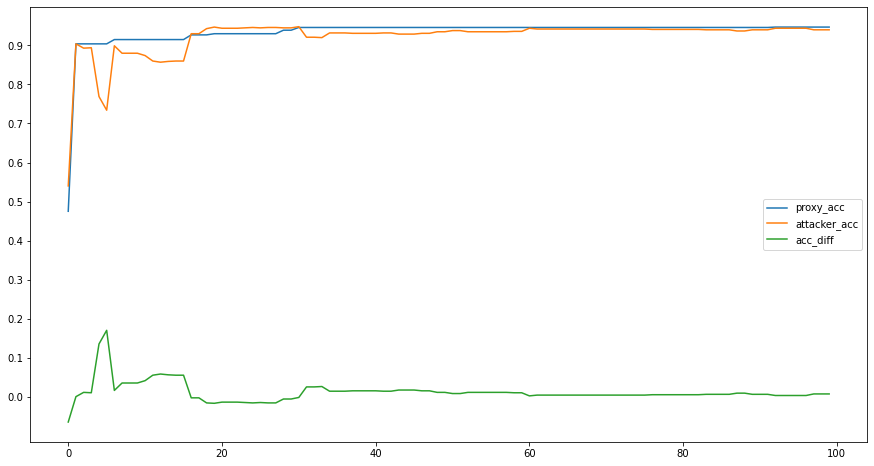

In [231]:
attacker_clf = LogisticRegression()
proxy = online_svm_qp(1.0) # 1.0 is a good default
attacker = naive_attacker(true_clf, attacker_clf)
naive_test = test_proxy(proxy, attacker, X, y, log = False)
naive_test.steal(100)

In [232]:
proxy.X_retained.shape

(16, 2)